In [1]:
# importação da biblioteca "pandas" com o alias "pd"
import pandas as pd  

# carregamento do dados exportados do banco de dados para um dataframe do pandas
dataset = pd.read_csv('dataset_reduzido.csv') 
# apresentação dos dados em tela para verificação do correto carregamento
print(dataset)

    ValPrecipitacao  ValMareMaxima  ValTemperaturaMaxima  ValHouveEnchente
0             68.00            1.8                  33.0                 1
1             43.00            1.7                  37.0                 1
2            139.00            1.7                  27.0                 1
3             65.00            1.3                  24.0                 1
4             91.00            1.2                  26.0                 1
5              7.37            1.2                  32.0                 0
6              0.23            1.2                  32.0                 0
7              0.23            1.2                  28.0                 0
8              5.49            1.3                  24.0                 0
9              9.83            1.5                  24.0                 0
10             0.91            1.7                  32.0                 0
11             2.74            1.7                  29.0                 0
12           142.50      

In [2]:
# carregamento das três variáveis a serem processadas em um novo dataframe pandas
# desconsiderando a coluna 'ValHouveEnchente' que é a coluna onde está armazenada 
# o resultado esperado
X = dataset.drop(['ValHouveEnchente'],axis=1).values
# aplicação da fórmula da normalização Z-score, onde a média é substraida dos 
# valores originais e posteriormente divididos pelo desvio padrão
X = (X -X.mean()) / X.std()
X

array([[ 0.76158845, -0.54809672,  0.06915671],
       [ 0.26699435, -0.5500751 ,  0.14829177],
       [ 2.16623568, -0.5500751 , -0.04954587],
       [ 0.70223715, -0.5579886 , -0.10889716],
       [ 1.21661501, -0.55996698, -0.06932964],
       [-0.43790116, -0.55996698,  0.04937295],
       [-0.57915723, -0.55996698,  0.04937295],
       [-0.57915723, -0.55996698, -0.02976211],
       [-0.47509463, -0.5579886 , -0.10889716],
       [-0.3892331 , -0.55403185, -0.10889716],
       [-0.56570427, -0.5500751 ,  0.04937295],
       [-0.52949998, -0.5500751 , -0.00997834],
       [ 2.23547885, -0.55403185,  0.06915671],
       [ 0.86050727, -0.54809672, -0.10889716],
       [ 0.76158845, -0.5579886 , -0.06932964],
       [ 2.72018107, -0.5500751 ,  0.04937295],
       [ 2.72018107, -0.5500751 , -0.04954587],
       [ 7.32979805, -0.55403185, -0.00997834],
       [ 0.64288586, -0.55601023,  0.02958918],
       [ 0.99899361, -0.5579886 , -0.0891134 ],
       [-0.44344061, -0.55205347, -0.168

In [3]:
X_validacao = X[-10:]
X = X[0:-10]

In [4]:
# carregamento dos dados da coluna 'ValHouveEnchente' em um dataframe pandas
# específico, esse dataframe será utilizado como base para determinar os resultados
# esperados, os quais a RNA usará para medir o progresso do seu aprendizado
y = dataset['ValHouveEnchente'].values

y_validacao = y[-10:]
y_validacao

y = y[0:-10]
y

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [5]:
# importação da biblioteca scikit-learn para separação dos datasets em carga de 
# treino e teste
from sklearn.model_selection import train_test_split

# separação dos datasets em 80% para treino e 20# para teste
# X_treino é a carga de dados para treinar a RNA
# X_teste são os dados separados para testar a RNA
# y_treino são os resultados esperados de cada conjunto presente no dataset de treino
# y_teste são os resultados esperados de cada conjunto presente no dataset de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2)


In [6]:
# importação da biblioteca PyTorch
import torch

# tranformação dos datasets em tensores do PyTorch
X_treino = torch.FloatTensor(X_treino)
X_teste = torch.FloatTensor(X_teste)
y_treino = torch.LongTensor(y_treino)
y_teste = torch.LongTensor(y_teste)

In [23]:
# importação das bibliotecas nn e nn.functional
import torch.nn as nn
import torch.nn.functional as F

# definição da RNA
class RedeNeuralArtificial(nn.Module):
  #
  def __init__(self,entrada=3,camada_escondida1=16,camada_escondida2=16,saida=2):
    super().__init__()
    self.fc1 = nn.Linear(entrada,camada_escondida1)
    self.fc2 = nn.Linear(camada_escondida1, camada_escondida2)
    self.out = nn.Linear(camada_escondida2, saida)
  
# a função forward é responsável por realizar a ativição entre as camadas da RNA
# a saída esperada da rede é sempre positivia e por isso a função ReLU é utilizada 
# para realizar a essa tarefa
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

In [24]:
# instanciação da classe RNA
modelo_classificacao = RedeNeuralArtificial()

# a função de medida de performance foi definida como Entropia Cruzada
# esta função é responsável por medir se a RNA está se aproximando do resultado esperado
funcao_performance = nn.CrossEntropyLoss()

# como os pesos iniciais atribuidos a cada neurônio são aleatórios, é necessário 
# utilizar um otimizador para ajustar esse valores conforme o treinamendo da RNA
# avança, neste caso foi utilizado o Algortimo de Adam
otimizador = torch.optim.Adam(modelo_classificacao.parameters(), lr=0.01)

In [25]:
# a variável 'epocas' determina a quantidade de vezes que os dados serão
# passados pela RNA para treiná-la
epocas = 1000
epc = []
custos = []

for i in range(epocas):
  # retorna o valor predito
  y_predito = modelo_classificacao.forward(X_treino)
  # calcula o custo 
  custo = funcao_performance(y_predito, y_treino)
  # dados armazenados em listas apenas para plotagem de gráfico
  custos.append(custo.item())
  epc.append(i+1)

# função zero_grad() tem por objetivo definir o gradiente como 0 antes de iniciar o
# processo de retropropagação
  otimizador.zero_grad()
# função backward() realiza o cálculo do gradiente
  custo.backward()
# atualiza os dados do otimizador conforme o gradiante atual
  otimizador.step()

print(("%.17f" % custos[-1:][0]).rstrip('0').rstrip('.'))

0.00135494268033653


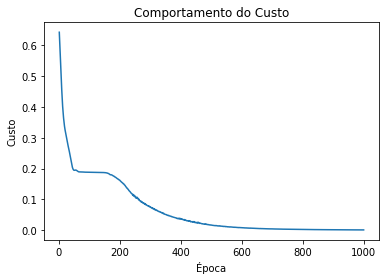

In [26]:
import matplotlib.pyplot as plt

plt.plot(epc, custos)
plt.title('Comportamento do Custo')
plt.xlabel('Época')
plt.ylabel('Custo')
plt.show()

In [27]:
predicoes = []

with torch.no_grad():
    for val in X_teste:
        y_predito = modelo_classificacao.forward(val)
        # print(y_predito)
        predicoes.append(y_predito.argmax().item())

df = pd.DataFrame({'Esperado': y_teste, 'Predição': predicoes})
df['Correto'] = [1 if corr == pred else 0 for corr, pred in zip(df['Esperado'], df['Predição'])]
df

,Esperado,Predição,Correto
0,0,0,1
1,1,1,1
2,0,0,1
3,0,0,1
4,1,1,1
5,0,0,1
6,0,0,1


In [28]:
X_val = torch.FloatTensor(X_validacao)
y_val = torch.LongTensor(y_validacao)

predicoes_novo =[]

with torch.no_grad():
    for val in X_val:
        y_predito_novo = modelo_classificacao.forward(val)
        predicoes_novo.append(y_predito_novo.argmax().item())

df2 = pd.DataFrame({'Esperado': y_val, 'Predição': predicoes_novo})
df2['Correto'] = [1 if corr == pred else 0 for corr, pred in zip(df2['Esperado'], df2['Predição'])]
df2

,Esperado,Predição,Correto
0,1,1,1
1,1,1,1
2,1,1,1
3,1,0,0
4,1,1,1
5,1,1,1
6,1,0,0
7,1,1,1
8,1,1,1
9,1,1,1
